<a href="https://colab.research.google.com/github/jjonhwa/DeepLearning.AI-TensorFlow/blob/main/39_S%2BP_Week_4_Exercise_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_series(time, series, format = '-', start = 0, end = None) :
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-01-19 13:13:35--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.001s  

2021-01-19 13:13:35 (43.7 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



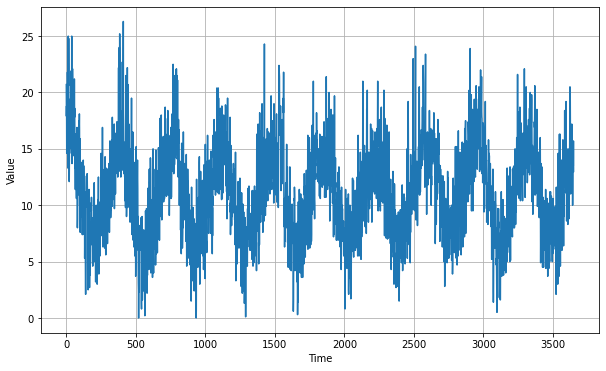

In [ ]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile :
  reader = csv.reader(csvfile, delimiter = ',')
  next(reader)
  step = 0

  for row in reader :
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize = (10, 6))
plot_series(time, series)

In [ ]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer) :
  series = tf.expand_dims(series, axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda x: x.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda x: (x[:-1], x[1:]))
  ds = ds.batch(batch_size).prefetch(1)

  return ds

In [ ]:
def model_forecast(model, series, window_size) :
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda x: x.batch(window_size))
  ds = ds.batch(32).prefetch(1)

  forecast = model.predict(ds)
  return forecast

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Lambda, Bidirectional, Conv1D

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    Conv1D(filters = 32, kernel_size = 5,
           strides  = 1, padding = 'causal',
           activation = 'relu',
           input_shape = [None, 1]),
    Bidirectional(LSTM(64, return_sequences = True)),
    Bidirectional(LSTM(64, return_sequences = True)),
    Dense(30, activation = 'relu'),
    Dense(10, activation = 'relu'),
    Dense(1),
    Lambda(lambda x: x* 400)
])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10 ** (epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])

history = model.fit(train_set, epochs = 100, callbacks = [lr_scheduler])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 7s 37ms/step - loss: 21.0075 - mae: 21.5054
Epoch 2/100
10/10 [==============================] - 0s 32ms/step - loss: 19.7809 - mae: 20.2786
Epoch 3/100
10/10 [==============================] - 0s 34ms/step - loss: 17.9388 - mae: 18.4360
Epoch 4/100
10/10 [==============================] - 0s 31ms/step - loss: 15.9328 - mae: 16.4294
Epoch 5/100
10/10 [==============================] - 0s 31ms/step - loss: 13.8870 - mae: 14.3828
Epoch 6/100
10/10 [==============================] - 0s 32ms/step - loss: 11.9245 - mae: 12.4186
Epoch 7/100
10/10 [==============================] - 0s 31ms/step - loss: 10.1961 - mae: 10.6884
Epoch 8/100
10/10 [==============================] - 0s 30ms/step - loss: 8.9995 - mae: 9.4900
Epoch 9/100
10/10 [==============================] - 0s 32ms/step - loss: 8.2376 - mae: 8.7257
Epoch 10/100
10/10 [=========

(1e-08, 0.0001, 0.0, 60.0)

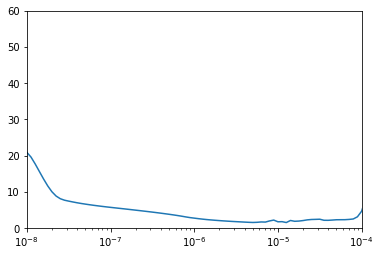

In [ ]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size = 100, shuffle_buffer = shuffle_buffer_size)

model = tf.keras.models.Sequential([
    Conv1D(filters = 32, kernel_size = 5,
           strides = 1, padding = 'causal',
           activation = 'relu',
           input_shape = [None, 1]),
    Bidirectional(LSTM(60, return_sequences = True)),
    Bidirectional(LSTM(60, return_sequences = True)),
    Dense(30, activation = 'relu'),
    Dense(10, activation = 'relu'),
    Dense(1),
    Lambda(lambda x: x * 400.0)
])

optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])

history = model.fit(train_set, epochs = 150)

Epoch 1/150
25/25 [==============================] - 5s 23ms/step - loss: 16.8948 - mae: 17.3794
Epoch 2/150
25/25 [==============================] - 1s 20ms/step - loss: 2.0996 - mae: 2.5526
Epoch 3/150
25/25 [==============================] - 1s 20ms/step - loss: 1.4491 - mae: 1.8907
Epoch 4/150
25/25 [==============================] - 1s 20ms/step - loss: 1.3147 - mae: 1.7523
Epoch 5/150
25/25 [==============================] - 1s 19ms/step - loss: 1.2638 - mae: 1.6996
Epoch 6/150
25/25 [==============================] - 1s 19ms/step - loss: 1.2076 - mae: 1.6414
Epoch 7/150
25/25 [==============================] - 1s 20ms/step - loss: 1.1850 - mae: 1.6178
Epoch 8/150
25/25 [==============================] - 1s 19ms/step - loss: 1.1529 - mae: 1.5849
Epoch 9/150
25/25 [==============================] - 1s 20ms/step - loss: 1.1267 - mae: 1.5575
Epoch 10/150
25/25 [==============================] - 1s 20ms/step - loss: 1.1263 - mae: 1.5568
Epoch 11/150
25/25 [===========================

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

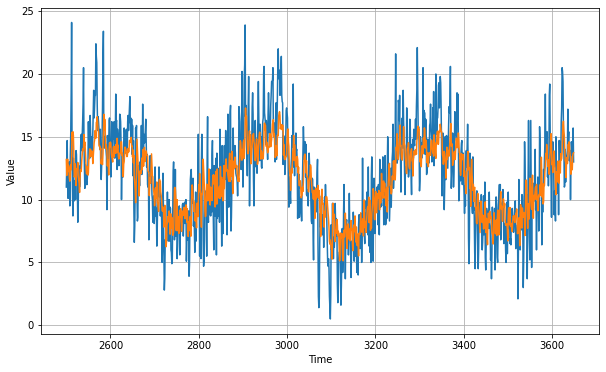

In [ ]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.0775206

In [ ]:
print(rnn_forecast)

[13.191589  11.919418  12.613762  ... 13.473153  13.666004  13.7232485]
